# Goal

Accuracy as a function of isotope incorporation

### Variable parameters:

* atom % isotope incorporation
  * 0, 25, 50, 100
* % taxa that incorporate
  * __1, 5, 10, 25, 50__
* n-reps (stocastic: taxon abundances & which incorporate)
  * 10 

## Init

In [2]:
import os
import glob
import itertools
import nestly

In [3]:
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


### BD min/max

In [5]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [6]:
# paths
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/'
buildDir = os.path.join(workDir, 'atomIncorp_taxaIncorp')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde.pkl'
genome_index = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

In [7]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)
%cd $buildDir

/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp


In [8]:
# making an experimental design file for qSIP
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(buildDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile       

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


## Nestly params

In [9]:
# building tree structure
nest = nestly.Nest()

# varying params: test
#nest.add('percIncorp', [100])
#nest.add('percTaxa', [10])
#nest.add('rep', range(1,4))

# varying params
nest.add('percIncorp', [0, 25, 50, 100])
nest.add('percTaxa', [1, 5, 10, 25, 50])
nest.add('rep', range(1,11))

## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('Monte_rep', [100000], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)
nest.add('DBL_scaling', [0.5], create_dir=False)
nest.add('bandwidth', [0.8], create_dir=False)
nest.add('heavy_BD_min', [1.71], create_dir=False)
nest.add('heavy_BD_max', [1.75], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('genome_index', [genome_index], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('exp_design', [expDesignFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

## Experimental design

In [179]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_expDesign.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_expDesign.sh'

In [180]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- Experimental design --#'

echo '# Making an isotope incorporation config file'
echo '## 3 replicate gradients for control & treatment'
SIPSim incorpConfigExample \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > incorp.config

echo '# Selecting incorporator taxa'
echo '## This is to make the gradient replicates consistent (qSIP finds mean among replicates)'
SIPSim KDE_selectTaxa \
    -p {percTaxa} \
    {fragFile} \
    > incorporators.txt

echo '# Creating a community file (3 replicate control, 3 replicate treatment)'
SIPSim communities \
    --config incorp.config \
    {genome_index} \
    > comm.txt    

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    --BD_min {min_BD} \
    --BD_max {max_BD} \
    comm.txt \
    > fracs.txt        

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_expDesign.sh


In [51]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file exp_design.log -j 10

2016-03-28 06:59:24,041 * INFO * Template: ./SIPSimRun.sh
2016-03-28 06:59:24,043 * INFO * [145094] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/7
2016-03-28 06:59:24,044 * INFO * [145095] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/9
2016-03-28 06:59:24,045 * INFO * [145097] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/8
2016-03-28 06:59:24,047 * INFO * [145099] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/3
2016-03-28 06:59:24,048 * INFO * [145101] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/10
2016-03-28 06:59:24,050 * INFO * [145103] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/2
2016-03-28 06:59:24,052 * INFO * [145105] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/1
2016-03-28 06:59:24,054 * INFO * [145107] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/4
2016-03-28 06:59:24,056 * INFO * [145109] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/5
2016-03-28 06:59:24,058 * INFO * [145111] Started ./SIPSimR

In [52]:
%pushnote exp_design complete: $buildDir

## SIPSim pipeline

In [182]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-pipeline.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-pipeline.sh'

In [183]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- SIPSim pipeline --#'    
    
echo '# Adding diffusion'    
SIPSim diffusion \
    -n {Monte_rep} \
    --bw {bandwidth} \
    --np {np} \
    {fragFile} \
    > ampFrags_KDE_dif.pkl    

echo '# Adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    -n {Monte_rep} \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --np {np} \
    ampFrags_KDE_dif.pkl \
    > ampFrags_KDE_dif_DBL.pkl 

echo '# Adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    -n {Monte_rep} \
    --comm comm.txt \
    --taxa incorporators.txt \
    --np {np} \
    ampFrags_KDE_dif_DBL.pkl \
    incorp.config \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# Simulating an OTU table'
SIPSim OTU_table \
    --abs {abs} \
    --np {np} \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    > OTU_abs{abs}.txt
    
echo '# Simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# Subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# Making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# Making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
       

#-- removing large intermediate files --#
rm -f ampFrags_KDE_dif.pkl
rm -f ampFrags_KDE_dif_DBL.pkl
rm -f ampFrags_KDE_dif_DBL_inc.pkl    

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-pipeline.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_pipeline.log -j 2

2016-03-28 07:01:04,305 * INFO * Template: ./SIPSimRun.sh
2016-03-28 07:01:04,307 * INFO * [167960] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/7
2016-03-28 07:01:04,308 * INFO * [167961] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/9
2016-03-28 07:32:58,553 * INFO * [167961] atomIncorp_taxaIncorp/50/50/9 Finished with 0
2016-03-28 07:32:58,631 * INFO * [168813] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/8
2016-03-28 07:38:10,926 * INFO * [167960] atomIncorp_taxaIncorp/50/50/7 Finished with 0
2016-03-28 07:38:10,952 * INFO * [169053] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/3
2016-03-28 08:06:02,932 * INFO * [168813] atomIncorp_taxaIncorp/50/50/8 Finished with 0
2016-03-28 08:06:02,954 * INFO * [170001] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/10
2016-03-28 08:08:42,327 * INFO * [169053] atomIncorp_taxaIncorp/50/50/3 Finished with 0
2016-03-28 08:08:42,345 * INFO * [170196] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/2
2

In [ ]:
%pushnote SIPSim pipeline complete: $buildDir

## Summary of simulated data

In [198]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-summary.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-summary.sh'

In [199]:
%%writefile $bashFileTmp
#!/bin/bash
   
# plotting 'raw' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}

# plotting 'sequenced' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}_PCR_sub.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}_PCR_sub

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-summary.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_summary.log -j 10

## HR-SIP: DESeq2

In [185]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_HRSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_HRSIP.sh'

In [186]:
%%writefile $bashFileTmp
#!/bin/bash

# phyloseq
## making phyloseq object from OTU table
SIPSimR phyloseq_make \
    OTU_abs{abs}_PCR_sub_w.txt \
    -s OTU_abs{abs}_PCR_sub_meta.txt \
    > OTU_abs{abs}_PCR_sub.physeq

## filtering phyloseq object to just 'heavy' fractions
SIPSimR phyloseq_edit \
    OTU_abs{abs}_PCR_sub.physeq \
    --BD_min {heavy_BD_min} \
    --BD_max {heavy_BD_max} \
    > OTU_abs{abs}_PCR_sub_filt.physeq

## making ordination
SIPSimR phyloseq_ordination \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    OTU_abs{abs}_PCR_sub_filt_bray-NMDS.pdf

# DESeq2
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    > OTU_abs{abs}_PCR_sub_filt_DESeq2

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_HRSIP.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file HR-SIP.log -j 10

In [ ]:
%pushnote HR-SIP complete: $buildDir

## qSIP

In [105]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_qSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_qSIP.sh'

In [106]:
%%writefile $bashFileTmp
#!/bin/bash


# qSIP
SIPSim qSIP \
    OTU_abs{abs}.txt \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_qSIP.txt
        

# qSIP: atom excess
SIPSim qSIP_atomExcess \
    --np {np} \
    OTU_abs{abs}_PCR_sub_qSIP.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_qSIP_atom.txt  

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_qSIP.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file qSIP.log -j 2

2016-04-07 13:06:21,844 * INFO * Template: ./SIPSimRun_qSIP.sh
2016-04-07 13:06:21,867 * INFO * [116857] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-04-07 13:06:21,874 * INFO * [116859] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9


In [ ]:
%pushnote qSIP complete: $buildDir

## Making confusion matrices

In [109]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_cMtx.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_cMtx.sh'

In [110]:
%%writefile $bashFileTmp
#!/bin/bash

# HR-SIP
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_DESeq2

# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_multi-cMtx \
    BD-shift_stats.txt \
    OTU_abs1e9_PCR_sub_BD3_DESeq2    
    
# qSIP    
SIPSimR qSIP_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_qSIP_atom.txt

# heavy-SIP    
SIPSimR heavy_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub.txt

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_cMtx.sh


In [111]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file cMtx.log -j 10

2016-04-11 06:47:56,122 * INFO * Template: ./SIPSimRun_cMtx.sh
2016-04-11 06:47:56,142 * INFO * [11230] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-04-11 06:47:56,144 * INFO * [11231] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9
2016-04-11 06:47:56,147 * INFO * [11233] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/8
2016-04-11 06:47:56,157 * INFO * [11236] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/3
2016-04-11 06:47:56,160 * INFO * [11238] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/10
2016-04-11 06:47:56,164 * INFO * [11240] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/2
2016-04-11 06:47:56,166 * INFO * [11242] Started

### Aggregating the confusion matrix data

In [112]:
def agg_cMtx(prefix):
    # all data
    #!nestagg delim \
    #    -d $buildDir \
    #    -k percIncorp,percTaxa,rep \
    #    -o $prefix-cMtx_data.txt \
    #    --tab \
    #    $prefix-cMtx_data.txt

    # overall
    x = prefix + '-cMtx_overall.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x

    # by class
    x = prefix + '-cMtx_byClass.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x
        
agg_cMtx('DESeq2')
agg_cMtx('qSIP') 
agg_cMtx('heavy') 

In [113]:
%pushnote atomIncorp_taxaIncorp complete!

***
# --End of simulation--#
***

# Plotting results

In [114]:
F = os.path.join(buildDir, '*-cMtx_byClass.txt')
files = glob.glob(F)
files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/DESeq2-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/qSIP-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/heavy-cMtx_byClass.txt']

In [115]:
%%R -i files

df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.4752475         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                     file method
1 DESeq2-cMtx_byClass.txt DESeq2
2 DESeq2-cMtx_byClass.txt DESeq2
3 DESeq2-cMtx_byClass.txt DESeq2


In [116]:
%%R
# renaming method
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'qSIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.4752475         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                     file method
1 DESeq2-cMtx_byClass.txt HR-SIP
2 DESeq2-cMtx_byClass.txt HR-SIP
3 DESeq2-cMtx_byClass.txt HR-SIP


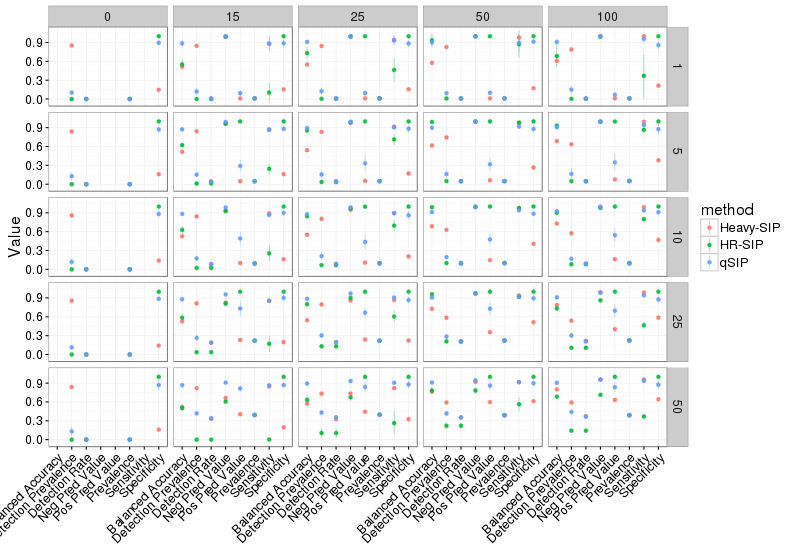

In [117]:
%%R -w 800 -h 550
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values),
              sd_value = sd(values))

# plotting
ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

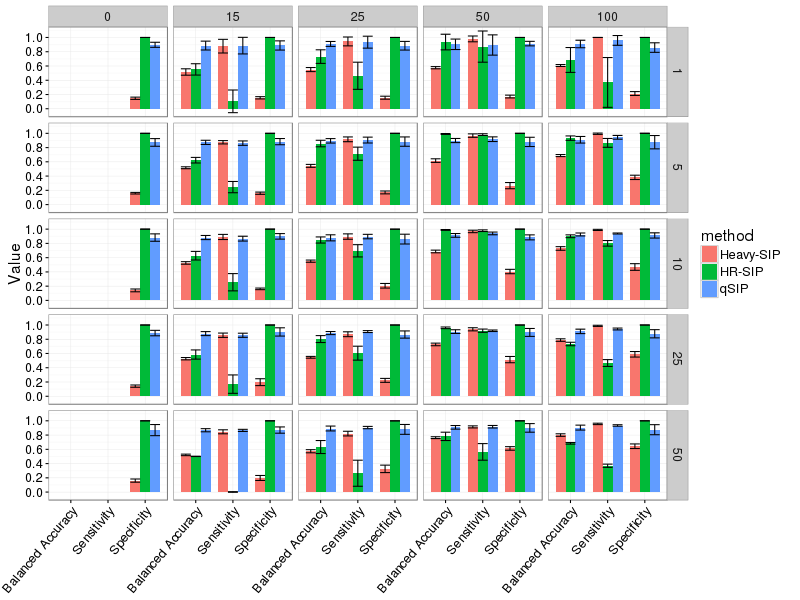

In [118]:
%%R -w 800 -h 600
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) 

# plotting
ggplot(df_byClass.s.f, aes(variables, mean_value, fill=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    #geom_pointrange(alpha=0.8, size=0.2) +
    geom_bar(stat='identity', position='dodge', width=0.8) +
    geom_errorbar(stat='identity', position='dodge', width=0.8) +
    scale_y_continuous(breaks=seq(0, 1, 0.2)) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=50, hjust=1)
    )

***

# --re-run--

* for all simulations that died due to a memory error

In [93]:
import glob

## Function for detecting missing/empty files

In [194]:
def find_missing_files(filepath, empty_cut=10000):
    # directories
    dirpath = os.path.split(filepath)[0]
    chk = os.path.join(buildDir, dirpath) + '/'
    D = set([os.path.split(x)[0] for x in glob.glob(chk)])
    
    # files
    chk = os.path.join(buildDir, filepath)
    F = glob.glob(chk)
    
    # check for missing files
    Fd = set([os.path.split(f)[0] for f in F])
    missing = D - Fd    
    print 'Union length: {}'.format(len(D | Fd))
    print 'Number of missing: {}'.format(len(missing))

    # check for empty files
    empties = [os.path.split(f)[0] for f in F if os.path.getsize(f) < empty_cut]
    print 'Number of empties: {}'.format(len(empties))
    
    # ret
    return {'missing' : list(missing), 'empty' : empties}
    
find_missing_files('*/*/*/OTU_abs1e9.txt')    

Union length: 200
Number of missing: 0
Number of empties: 1


{'empty': ['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6'],
 'missing': []}

## Finding all SIPSim pipeline incompletes

In [195]:
pipeline_me = find_missing_files('*/*/*/OTU_abs1e9.txt')   

Union length: 200
Number of missing: 0
Number of empties: 1


In [196]:
pipeline_me

{'empty': ['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6'],
 'missing': []}

In [197]:
# rerunning 
exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_SIPSim-pipeline.sh'
exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSim_pipeline.log'
!$exe 
%pushnote SIPSim pipeline rerun complete

#-- SIPSim pipeline --#
# Adding diffusion
# Adding DBL contamination; abundance-weighted smearing
# Adding isotope incorporation to BD distribution
# Simulating an OTU table
# Simulating PCR
# Subsampling from the OTU table (simulating sequencing of the DNA pool)
# Making a wide-formatted table
# Making metadata (phyloseq: sample_data)


In [205]:
exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_SIPSim-summary.sh'
exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSim_summary.log'
!$exe 
%pushnote pipeline summary rerun complete

In [202]:
# exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_HRSIP.sh'
# exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/HR-SIP.log'
# !$exe 
# %pushnote HRSIP rerun complete

In [203]:
pipeline_me = find_missing_files('*/*/*/OTU_abs1e9.txt')  

Union length: 200
Number of missing: 0
Number of empties: 1


## Finding all HR-SIP incompletes

In [231]:
HRSIP_me = find_missing_files('*/*/*/OTU_abs1e9_PCR_sub_filt_DESeq2') 

Union length: 200
Number of missing: 75
Number of empties: 0


In [238]:
def run_HRSIP(dirpath):
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_HRSIP.sh', 'HR-SIP.log')
    !$cmd

for FL in HRSIP_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_HRSIP(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/1
Square root transformation
Wisconsin double standardization
Run 0 stress 0.1306591 
Run 1 stress 0.1303777 
... New best solution
... procrustes: rmse 0.007102089  max resid 0.0444321 
Run 2 stress 0.1948695 
Run 3 stress 0.1306245 
... procrustes: rmse 0.007451967  max resid 0.04495998 
Run 4 stress 0.130682 
... procrustes: rmse 0.006855106  max resid 0.04451128 
Run 5 stress 0.2935093 
Run 6 stress 0.2017967 
Run 7 stress 0.1302226 
... New best solution
... procrustes: rmse 0.003597437  max resid 0.01851154 
Run 8 stress 0.1835123 
Run 9 stress 0.130223 
... procrustes: rmse 4.537866e-05  max resid 0.0001128968 
*** Solution reached
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/5/3
Square root transformation
Wisconsin double standardization
Run 0 stress 0.08853476 
Run 1 stress 0.08856917 
... procrustes: rmse 0.001831047  max resid 0.01022147 
Run 2 stress 0

In [239]:
HRSIP_me = find_missing_files('*/*/*/OTU_abs1e9_PCR_sub_filt_DESeq2') 

Union length: 200
Number of missing: 0
Number of empties: 0


## Finding all qSIP pipeline incompletes

In [212]:
qSIP_me = find_missing_files('*/*/*/*qSIP_atom.txt')  

Union length: 200
Number of missing: 80
Number of empties: 1


### re-running qSIP

In [ ]:
def run_qSIP(dirpath):
    #cmd = os.path.join(dirpath, 'SIPSimRun_qSIP.sh')
    #log = os.path.join(dirpath, 'qSIP.log')
    cmd = 'cd {}; perl -pi -e "s/--np 10/--np 20/" {}'.format(dirpath, 'SIPSimRun_qSIP.sh')
    !$cmd
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_qSIP.sh', 'qSIP.log')
    !$cmd

for FL in qSIP_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_qSIP(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6


In [ ]:
%pushnote qSIP rerun complete

### re-running cMtx

In [228]:
cMtx_me = find_missing_files('*/*/*/qSIP-cMtx_overall.txt', empty_cut=200)  

Union length: 200
Number of missing: 82
Number of empties: 0


In [242]:
def run_cMtx(dirpath):
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_cMtx.sh', 'cMtx.log')
    !$cmd

for FL in cMtx_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_cMtx(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/1
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/5/3
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/3
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/2
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/5
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/4
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/7
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/6
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/9
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/8
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/25/9
Processing: /home/nick/notebook/S

In [243]:
cMtx_me = find_missing_files('*/*/*/qSIP-cMtx_overall.txt', empty_cut=200)  

Union length: 200
Number of missing: 0
Number of empties: 0


In [244]:
%pushnote cMtx rerun complete

# -- Sandbox --#

In [97]:
%%R
df = data.frame(A = c(TRUE, FALSE, TRUE, TRUE))
df %>% mutate(lag(A))

      A lag(A)
1  TRUE     NA
2 FALSE   TRUE
3  TRUE  FALSE
4  TRUE   TRUE
